# Project Description.


- This project/program will be able to detect whether a message is spam or not spam

- The messages can either be Spam mail or Ham which stands for not spam
- This is a classification problem specifically a binary classification problem

# Importing important libraries



In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import pickle
import tensorflow as tf

# For text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# For model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split




# Load the Dataset

In [77]:
from google.colab import files
uploaded = files.upload() 

Saving spam.csv to spam (1).csv


In [78]:
data = pd.read_csv("spam.csv", encoding ='latin-1')
data.sample()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
236,ham,Or ill be a little closer like at the bus stop...,NaN,NaN,NaN


# Prepare the Dataset

In [79]:
# Drop the columns labeled Unnamed
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

In [80]:
# Rename the columns v1 and v2
data = data.rename(columns={"v1":"label", "v2":"text"})
data.sample()

,label,text
2302,ham,We can make a baby in yo tho


In [81]:
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Mapping Spam to 1 and Ham to 0 will make it easier during training of the model

In [82]:
data['label'] = data['label'].map( {'spam': 1, 'ham': 0} )

# Tokenization and Embedding

In [83]:
# Specifying the X and y values to be used for training
X = data['text'].values
y = data['label'].values


In [84]:
# Split the data into train sets and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [85]:
# Prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train)


In [86]:
# Integer encode the documents
encoded_train = t.texts_to_sequences(X_train)
encoded_test = t.texts_to_sequences(X_test)

In [87]:
# Padding - Ensuring the input data is in the same shape and length
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

# Training the model

In [88]:
vocab_size = len(t.word_index) + 1

In [89]:
# Defining the model

model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [90]:
# Compiling the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [91]:
# Summarize the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 24)             190920    
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               96500     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [92]:
# Apply ealry stopping- the model trains for a numbe rof epochs and stops if the model is not improving anymore.
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience= 10)

In [93]:
# Fitting the model
model.fit(x=padded_train,y=y_train,epochs=50,validation_data=(padded_test, y_test), verbose=1,callbacks=[early_stop])

Epoch 1/50
140/140 [==============================] - 2s 10ms/step - loss: 0.1959 - accuracy: 0.9206 - val_loss: 0.1114 - val_accuracy: 0.9740
Epoch 2/50
140/140 [==============================] - 1s 8ms/step - loss: 0.0469 - accuracy: 0.9861 - val_loss: 0.0965 - val_accuracy: 0.9812
Epoch 3/50
140/140 [==============================] - 1s 8ms/step - loss: 0.0167 - accuracy: 0.9948 - val_loss: 0.1238 - val_accuracy: 0.9803
Epoch 4/50
140/140 [==============================] - 1s 8ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.2190 - val_accuracy: 0.9830
Epoch 5/50
140/140 [==============================] - 1s 8ms/step - loss: 2.1527e-06 - accuracy: 1.0000 - val_loss: 0.3277 - val_accuracy: 0.9830
Epoch 6/50
140/140 [==============================] - 1s 8ms/step - loss: 1.9734e-08 - accuracy: 1.0000 - val_loss: 0.3463 - val_accuracy: 0.9830
Epoch 7/50
140/140 [==============================] - 1s 8ms/step - loss: 1.8468e-09 - accuracy: 1.0000 - val_loss: 0.3626 - val_accuracy: 

# Evaluating the Permance metrics


In [94]:
# Building a classification report and a confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')


In [95]:
# Making a prediction 
preds = (model.predict(padded_test) > 0.5).astype("int32")


In [96]:
# Classification report
c_report(y_test, preds)


Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.88      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy : 0.9820627802690582


0.9820627802690582

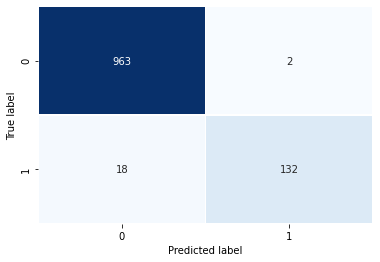

In [97]:
# Confusion matrix
plot_confusion_matrix(y_test, preds)

- From the confuson matrix and the classification report we can conclude that the model is genreally performing well since it has high precision, recall , f1-score and accuracy values.

- The confusion matrix also hows how well the model is performing since it has 963 True positives out of 965 and 132 true negatives out of 150
- These metrics however may vary every time the program is run

In [98]:
# Saving the trained model
model.save("spam_model")


INFO:tensorflow:Assets written to: spam_model/assets
